# Module 9: Convolutional Neural Networks
## **Lab 3**
### Module coordinator: Kushagra Agarwal

## 1. Understanding Convolutions

<img src="https://miro.medium.com/max/464/0*e-SMFTzO8r7skkpc" width=650px/>

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

Central to CNNs, a convolution operation is a linear element-wise multiplication operation between a small filter/kernel and same-sized patch from the image. We move this filter over the image like a sliding window from top left to bottom right. For each point on the image, a value is calculated based on the filter using a convolution operation. These filters can do simplest task like checking if there is a vertical line in the image or complicated task like detecting a human eye in the image.

Let's look at the convolution formula:

Convolution between image
$f(x, y)$ and kernel $k(x, y)$ is
$$f(x,y) * k(x,y) = \sum \limits _{i=0} ^{W-1} \sum \limits _{j=0} ^{H-1} f(i, j) k(x − i, y − j)$$

where $W$ and $H$ are the the width and height of the image.

The code demonstrates the convolution operation of a 2D matrix (image) with various filters

<img src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png" alt="Convolution" width=650px height=280px/>

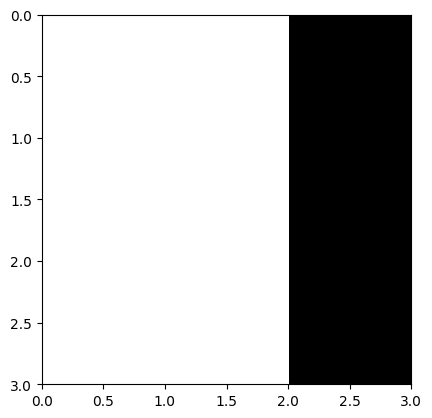

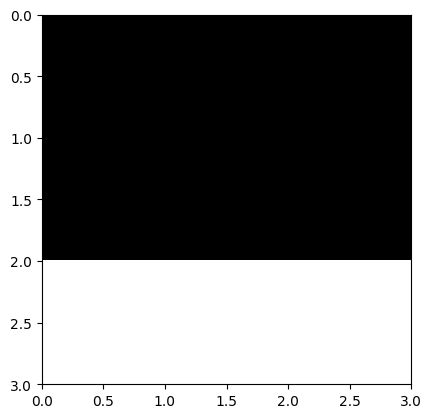

In [4]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [5]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [6]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image. Similarly, horizontal edge is detected in second.

Let's define a function to use convolution layer from Pytorch and use our own kernel to detect edges in image

In [7]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

In [18]:
# Our original lotus image
image = cv2.imread('/content/grid1.jpg', 0)

filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

out1 = apply_conv(image, filter, padding=0, stride=1)

filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

out2 = apply_conv(image, filter, padding=0, stride=1)

In [ ]:

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,3,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image')
ax = fig.add_subplot(1,3,2)
ax.set_title('Horizontal edge')
ax.imshow(out1, cmap='gray')
ax = fig.add_subplot(1,3,3)
ax.imshow(out2, cmap='gray')
ax.set_title('Vertical edge')
plt.show()


## Pooling Layers

Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.

1) Max Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png' height=150px/>

2) Average Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png' height=150px/>

## Softmax layer/activation
Recall that logistic regression produces a decimal between 0 and 1.0. For example, a logistic regression output of 0.8 from an email classifier suggests an 80% chance of an email being spam and a 20% chance of it being not spam. Clearly, the sum of the probabilities of an email being either spam or not spam is 1.0.

Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.
Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer.

<img src='https://miro.medium.com/max/1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg' height=170px />

## Learning to train a CNN network

In [26]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [27]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 49287291.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [28]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [29]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [30]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [31]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [33]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [34]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [35]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/5, Loss: 0.0133, Accuracy: 37.6720
Epoch 2/5, Loss: 0.0095, Accuracy: 56.6540
Epoch 3/5, Loss: 0.0079, Accuracy: 64.3880
Epoch 4/5, Loss: 0.0068, Accuracy: 69.3320
Epoch 5/5, Loss: 0.0059, Accuracy: 73.5880


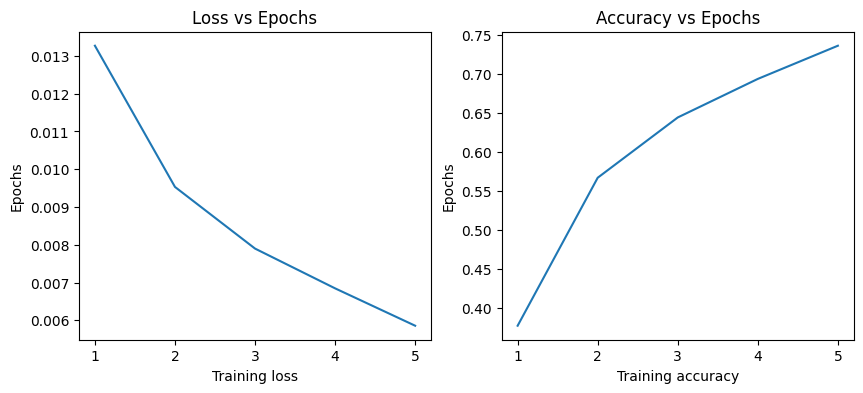

In [36]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [37]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 68 %


## Questions
1) List some reasons why we should prefer CNN over ANN for image classification?

2) Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc). Report the improved test accuracy.

3) What happens if you reduce the number of convolution layers to only 1?

4) Why didn't we use the Softmax activation in the last layer of CNN?


**QUESTION 1**
Convolutional Neural Networks (CNNs) are generally preferred over Artificial Neural Networks (ANNs) for image classification tasks due to several reasons:

**Hierarchical feature learning:** CNNs are specifically designed to capture hierarchical spatial patterns in data. They utilize convolutional layers to extract low-level features like edges and textures, which are then combined in deeper layers to form more complex features. ANNs, on the other hand, treat input data as flat vectors, lacking the ability to capture spatial relationships inherent in images.

**Parameter sharing:** CNNs leverage parameter sharing by using the same set of weights (kernel) across different spatial locations in an image. This reduces the number of parameters in the model and enables efficient learning of translation-invariant features. In ANNs, each neuron in a layer is connected to all neurons in the previous layer, resulting in a large number of parameters, which can lead to overfitting, especially for high-dimensional data like images.

**Spatial invariance:** CNNs are inherently spatially invariant due to the use of convolutional and pooling layers. This means that they can recognize patterns regardless of their location in the input image. ANNs, however, require explicit translation invariance mechanisms to achieve similar performance.

**Feature reuse:** CNNs learn to reuse learned features across different parts of the image. Once a feature detector (e.g., an edge detector) is learned in one part of the image, it can be applied to other parts as well. ANNs lack this ability to efficiently reuse learned features, as they treat each input feature independently.

**Efficient computation:** CNNs are computationally efficient due to their parameter sharing and sparse connectivity, especially in comparison to fully connected ANNs. This makes CNNs well-suited for processing large-scale image data, as they can exploit parallelism and GPU acceleration effectively.

**Regularization:** CNN architectures often include regularization techniques such as dropout and weight decay, which help prevent overfitting and improve generalization performance. While ANNs can also benefit from regularization, CNNs inherently have a more structured architecture, making it easier to incorporate and apply regularization techniques effectively.

**State-of-the-art performance:** CNNs have consistently achieved state-of-the-art performance on various image classification benchmarks, including datasets like ImageNet. Their ability to learn hierarchical features and spatial relationships makes them well-suited for handling the complexities of real-world image data

**QUESTION 3**

When you reduce the number of convolutional layers in a Convolutional Neural Network (CNN) architecture to only one:

**Limited Feature Learning:** With only one convolutional layer, the model has limited capacity to learn hierarchical features from the input data. This layer can still capture basic patterns like edges or textures, but it may struggle to extract more complex features necessary for accurate classification.

**Shallower Representation:** The network's representation of the input data becomes shallower. Each convolutional layer typically captures increasingly abstract and complex features. With only one layer, the model's representation of the input data is less deep, potentially limiting its ability to understand complex structures within the images.

**Reduced Model Complexity:** The overall complexity of the model decreases. Fewer parameters are needed to train the network, which can lead to faster training times and lower computational resources required for both training and inference. However, this reduction in complexity comes at the cost of the model's ability to learn intricate patterns.

**Limited Generalization:** The model may struggle to generalize well to unseen data. A shallower representation of the input data might result in a lack of robustness to variations and complexities present in real-world images. This limitation can lead to poorer performance on image classification tasks, especially on datasets with diverse or complex images.

**Increased Risk of Underfitting:** With fewer convolutional layers, there's an increased risk of underfitting the training data. The model may not capture enough information from the data to learn meaningful patterns, resulting in poor performance on both the training and test sets.

**QUESTION 4**

If Softmax activation wasn't used in the last layer of the CNN, it could be due to several reasons:

**Binary Classification:** If the task is binary classification (i.e., there are only two classes), it's common to use a single neuron in the output layer with a sigmoid activation function instead of Softmax. The sigmoid function squashes the output between 0 and 1, representing the probability of the input belonging to one of the two classes.

**Model Design Choice:** Sometimes, Softmax activation may not be necessary or optimal depending on the specific requirements of the task or the design choices made in the CNN architecture. For example, if the task involves multi-label classification rather than multi-class classification, other activation functions or loss functions might be more appropriate.

**Regression Tasks:** In some cases, the output of the CNN might not require probabilistic interpretation. For regression tasks, where the goal is to predict a continuous value rather than a class label, the output layer might use a linear activation function instead of Softmax.

**Specialized Architectures:** In certain specialized architectures or models, the final layer might be designed differently to serve a specific purpose. For example, in Siamese networks used for similarity learning, the output layer might have a different structure or activation function tailored to the task.

**Experimentation:** It's possible that Softmax activation was experimented with during model development, but it didn't lead to improved performance or convergence. In such cases, alternative activation functions might be preferred based on empirical results.